In [93]:
import numpy as np
import pandas as pd
import pickle
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl

In [44]:
Market_position_df = pd.read_pickle('database\MarketPortfolioWeights26Oct20.pickle')
Momentum_position_df = pd.read_pickle('database\MomentumPortfolioWeights26Oct20.pickle')
Quality_position_df = pd.read_pickle('database\QualityPortfolioWeights26Oct20.pickle')
Value_position_df = pd.read_pickle('database\ValuePortfolioWeights26Oct20.pickle')
Liquidity_position_df = pd.read_pickle('database\LiquidityPortfolioWeights26Oct20.pickle')
Size_position_df = pd.read_pickle('database\SizePortfolioWeights26Oct20.pickle')
price_df = pd.read_pickle('database\\nifty_200_stocks_price_data_24Oct20.pickle')

In [50]:
price_subset_df = price_df[['adjclose','Symbol']]
price_subset_df.index = price_df['formatted_date' ]

In [66]:
nifty_200 = pd.read_csv('database\ind_nifty200list.csv')
price_matrix = {}
for stock in nifty_200.Symbol:
    price_matrix[stock] = price_subset_df[price_subset_df.Symbol == stock]

In [67]:
for stock in nifty_200.Symbol:
    price_matrix[stock].drop(columns='Symbol', inplace = True)
    price_matrix[stock] = price_matrix[stock].iloc[-18:,:]
final_price_matrix = pd.concat(price_matrix, axis = 1)
final_price_matrix.columns = final_price_matrix.columns.droplevel(1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [218]:
def Capstone_backtest(position_weight_df,prices_df,commission):
    cap = 70000000
    No_of_shares = {}
    for i in range(len(position_weight_df)):
        if i == 0:
            No_of_shares[position_weight_df.index[i]] = (cap*position_weight_df.iloc[i,:])/prices_df.iloc[i,:]
        else:
            cap = (No_of_shares[position_weight_df.index[i-1]]*prices_df.iloc[i,:]).sum()
            No_of_shares[position_weight_df.index[i]] = (cap*position_weight_df.iloc[i,:])/prices_df.iloc[i,:]
    position_df = pd.concat(No_of_shares,axis=1).T
    
    riskfree_rate = 0.02
    delta_df = position_df.diff()
    worth_df = position_df*prices_df
    worth_df['Total'] = worth_df.sum(axis=1)
    returns_df = delta_df*prices_df
    k = returns_df
    returns_df["returns"] = k.sum(axis=1)-k.abs().sum(axis=1)*commission
    returns_df["per_returns"] = returns_df["returns"]/worth_df['Total']
    sharpe_ratio = (returns_df["per_returns"].mean()-riskfree_rate)/returns_df["per_returns"].std()
    running_max = np.maximum.accumulate(worth_df['Total'])
    running_max[running_max < 1] = 1
    drawdown = (worth_df['Total'])/running_max - 1
    max_drawdown = drawdown.min()
    target = 0
    returns_df['downside_returns'] = 0
    returns_df.loc[returns_df['returns'] < target, 'downside_returns'] = returns_df['returns']**2
    down_stdev = np.sqrt(returns_df['downside_returns'].mean())
    sortino_ratio = (returns_df['returns'].mean() - riskfree_rate)/down_stdev

    # Print
    print('\n')
    start = "2016-08-31"
    end = "2020-10-10"

    print("Start\t\t\t\t\t", start)
    print("End\t\t\t\t\t", end)
    print("Portfolio Final Value [₹]\t\t", worth_df['Total'][-1])
    print("Portfolio Initial Value [₹]\t\t", worth_df['Total'][0])
    print("Portfolio peak [Rs]\t\t\t", worth_df['Total'].max())
    print("Return [%]\t\t\t\t", round((worth_df['Total'][-1]/worth_df['Total'][0]-1)*100,2))
    print("Max. Drawdown [%]\t\t\t", round(abs(max_drawdown)*100,1))
    print("Avg. Drawdown [%]\t\t\t", round(abs(drawdown.mean())*100,1))
    print("Sharpe Ratio\t\t\t\t", round(sharpe_ratio,3))
    print("Sortino Ratio\t\t\t\t", round(sortino_ratio,3))

     # Plot

    mpl.style.use('seaborn')
    fig, axs = plt.subplots(3, 1)

    axs[0].plot(worth_df['Total'],color='blue')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Portfolio Value [₹]')
    axs[0].grid(True)

    axs[1].plot(returns_df["returns"],dashes=[6, 2])
    axs[1].set_ylabel('Cumm. returns')
    axs[1].set_xlabel('Date')
    axs[1].grid(True)

    axs[2].plot(drawdown.abs()*100,color='red',dashes=[6, 2])
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Drawdown %')
    axs[2].grid(True)

    fig.autofmt_xdate()
    plt.show()

Market position


Start					 2016-08-31
End					 2020-10-10
Portfolio Final Value [₹]		 72564951.74964333
Portfolio Initial Value [₹]		 70000000.0
Portfolio peak [Rs]			 76702690.2126279
Return [%]				 3.66
Max. Drawdown [%]			 46.9
Avg. Drawdown [%]			 12.4
Sharpe Ratio				 -7.747
Sortino Ratio				 -0.845


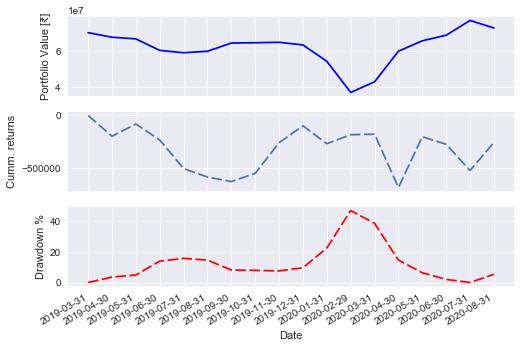

Momentum position


Start					 2016-08-31
End					 2020-10-10
Portfolio Final Value [₹]		 62902799.0838311
Portfolio Initial Value [₹]		 70000000.0
Portfolio peak [Rs]			 78430446.97717714
Return [%]				 -10.14
Max. Drawdown [%]			 38.4
Avg. Drawdown [%]			 11.3
Sharpe Ratio				 -6.159
Sortino Ratio				 -0.876


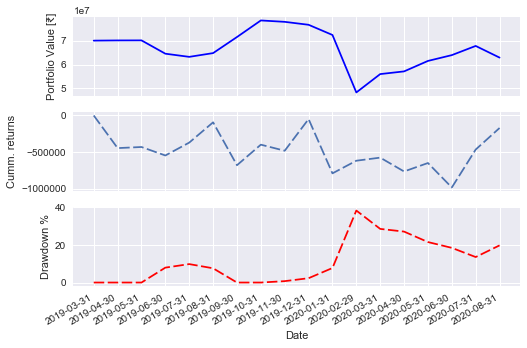

Quality position


Start					 2016-08-31
End					 2020-10-10
Portfolio Final Value [₹]		 60546859.03049815
Portfolio Initial Value [₹]		 70000000.0
Portfolio peak [Rs]			 72191879.44435659
Return [%]				 -13.5
Max. Drawdown [%]			 46.1
Avg. Drawdown [%]			 16.0
Sharpe Ratio				 -9.194
Sortino Ratio				 -0.924


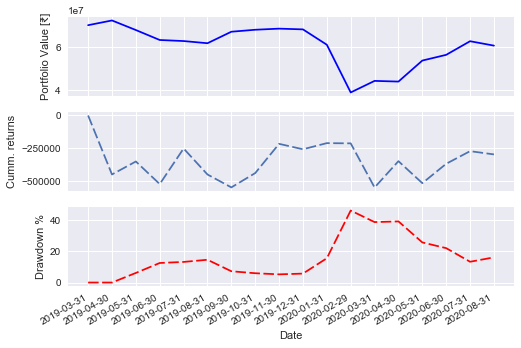

Value position


Start					 2016-08-31
End					 2020-10-10
Portfolio Final Value [₹]		 82996580.4541497
Portfolio Initial Value [₹]		 70000000.0
Portfolio peak [Rs]			 87874363.19628942
Return [%]				 18.57
Max. Drawdown [%]			 44.6
Avg. Drawdown [%]			 8.1
Sharpe Ratio				 -7.031
Sortino Ratio				 -0.883


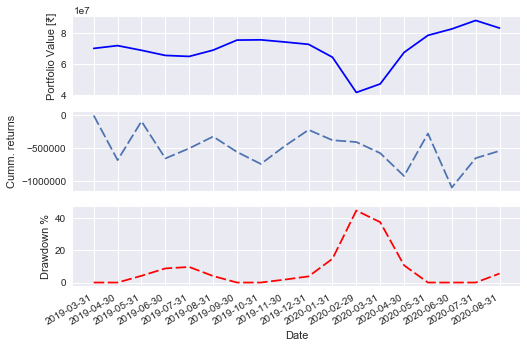

Liquidity position


Start					 2016-08-31
End					 2020-10-10
Portfolio Final Value [₹]		 92437698.0009335
Portfolio Initial Value [₹]		 70000000.0
Portfolio peak [Rs]			 97610195.29792133
Return [%]				 32.05
Max. Drawdown [%]			 43.2
Avg. Drawdown [%]			 8.7
Sharpe Ratio				 -0.552
Sortino Ratio				 -0.171


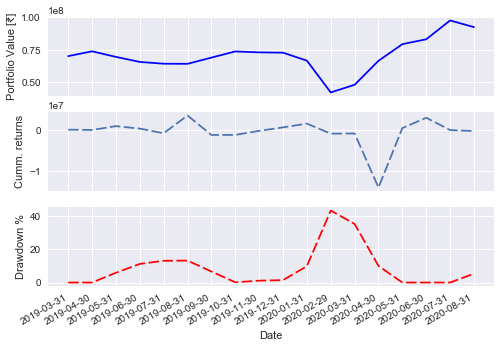

Size position


Start					 2016-08-31
End					 2020-10-10
Portfolio Final Value [₹]		 61978917.48033706
Portfolio Initial Value [₹]		 70000000.0
Portfolio peak [Rs]			 70262541.71130541
Return [%]				 -11.46
Max. Drawdown [%]			 39.6
Avg. Drawdown [%]			 11.9
Sharpe Ratio				 -8.871
Sortino Ratio				 -0.903


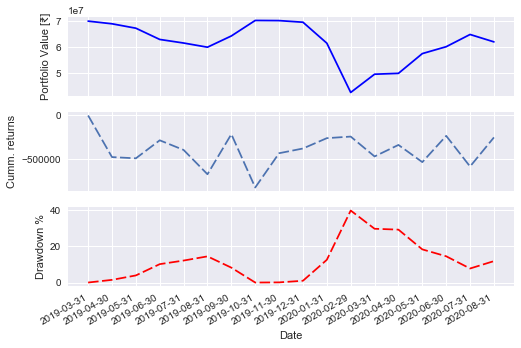

In [219]:
print(  "\033[4m"+"\033[1m" + "Market position" + "\033[0m"+"\033[0m")
Capstone_backtest(Market_position_df,final_price_matrix,0.01)

print(  "\033[4m"+"\033[1m" + "Momentum position" + "\033[0m"+"\033[0m")
Capstone_backtest(Momentum_position_df,final_price_matrix,0.01)

print(  "\033[4m"+"\033[1m" + "Quality position" + "\033[0m"+"\033[0m")
Capstone_backtest(Quality_position_df,final_price_matrix,0.01)

print(  "\033[4m"+"\033[1m" + "Value position" + "\033[0m"+"\033[0m")
Capstone_backtest(Value_position_df,final_price_matrix,0.01)

print(  "\033[4m"+"\033[1m" + "Liquidity position" + "\033[0m"+"\033[0m")
Capstone_backtest(Liquidity_position_df,final_price_matrix,0.01)

print(  "\033[4m"+"\033[1m" + "Size position" + "\033[0m"+"\033[0m")
Capstone_backtest(Size_position_df,final_price_matrix,0.01)

# Market_position_df
# Momentum_position_df
# Quality_position_df
# Value_position_df
# Liquidity_position_df
# Size_position_df